# AI Applications - Mini Project 2
> By Oliver Dietsche & Simon Peier

## Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image

## Dataset
We decided to use part of the [Tiny ImageNet](https://www.kaggle.com/c/tiny-imagenet) dataset. 

According to the description in Kaggle, the Tiny ImageNet dataset has the following properties: "Tiny ImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones." It fulfills all the required key characteristics, except that it has too many classes (and thus too many samples). To meet all criteria, we pre-processed the data-set and chose 6 classes to use. As the dataset contains lots of classes of different categories, we settled for classes from the animal realm.

### Dataset import

In [2]:
data_dir = "dataset"
words_file = os.path.join(data_dir, "words.txt")
image_size = (64, 64)

# Load words.txt
with open(words_file, 'r') as f:
    class_labels = {}
    for line in f:
        line = line.strip().split('\t')
        class_labels[line[0]] = line[1]

label_to_int_map = {label: i for i, label in enumerate(class_labels.values())}

def label_to_int(label):
    return label_to_int_map[label]

def int_to_label(intVal):
    return label_to_int_map.keys()[intVal]

# Load images and labels
images = []
labels = []

for folder_name in os.listdir(data_dir):
    if folder_name.startswith('n'):
        label = label_to_int(class_labels[folder_name])
        image_folder_path = os.path.join(data_dir, folder_name, "images")
        for image_name in os.listdir(image_folder_path):
            image_path = os.path.join(image_folder_path, image_name)
            image = img_to_array(load_img(image_path))
            images.append(image)
            labels.append(label)

images = np.array(images)
labels = np.array(labels)

### Normalization

In [3]:
print(f"Range of pixel values: [{images.min()};{images.max()}]")

images = images / 255.0

print(f"Range of pixel values: [{images.min()};{images.max()}]")

Range of pixel values: [0.0;255.0]
Range of pixel values: [0.0;1.0]


### Dataset split

In [4]:
# split into test and training data
train_val_imgs, test_imgs, train_val_labels, test_labels = train_test_split(images, labels, test_size=0.3)

In [5]:
# split into training and validation data
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_val_imgs, train_val_labels, test_size=0.2)

### Visualization

Total samples:       3000
Testing samples:     900
Training samples:    1680
Validation samples:  420

Image height:        64
Image width:         64
Number of channels:  3


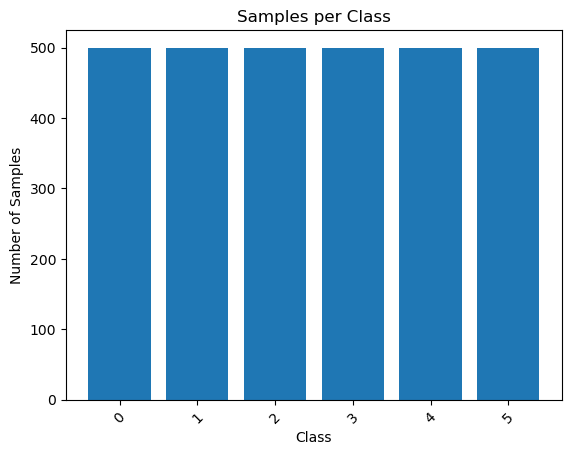

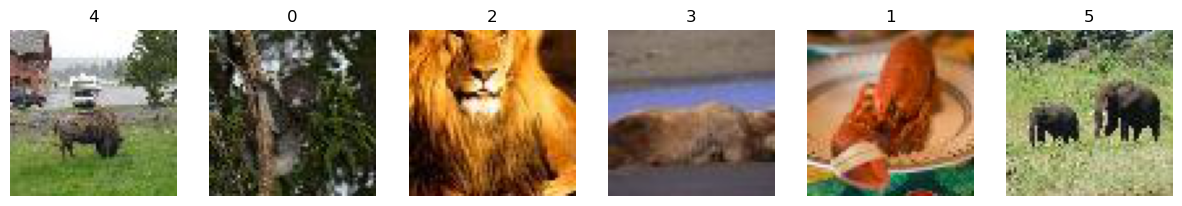

In [6]:
# Collect and print image stats
(total_samples, image_height, image_width, num_channels) = images.shape
test_samples = test_imgs.shape[0]
train_samples = train_imgs.shape[0]
val_samples = val_imgs.shape[0]
print(f"Total samples:       {total_samples}")
print(f"Testing samples:     {test_samples}")
print(f"Training samples:    {train_samples}")
print(f"Validation samples:  {val_samples}\n")
print(f"Image height:        {image_height}")
print(f"Image width:         {image_width}")
print(f"Number of channels:  {num_channels}")

# Count samples per class
samples_per_class = {}
for label in labels:
    samples_per_class[label] = samples_per_class.get(label, 0) + 1

# Determine if dataset is balanced
class_labels = list(samples_per_class.keys())
class_counts = list(samples_per_class.values())
plt.bar(class_labels, class_counts)
plt.title('Samples per Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Plot sample image for every class
num_samples_to_plot = 6
classes_to_plot = np.random.choice(list(samples_per_class.keys()), num_samples_to_plot, replace=False)

fig, axs = plt.subplots(1, num_samples_to_plot, figsize=(15, 3))

for i, class_label in enumerate(classes_to_plot):
    class_indices = np.where(labels == class_label)[0]
    sample_index = np.random.choice(class_indices)
    sample_image = images[sample_index]
    axs[i].imshow(sample_image)
    axs[i].set_title(class_label)
    axs[i].axis('off')

plt.show()

## Underfitting

In [7]:
num_classes = len(class_labels)

model = models.Sequential([
    layers.Conv2D(8, (2, 2), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D((4, 4)),
    layers.Conv2D(16, (2, 2), activation='relu', strides=(2, 2)),
    layers.MaxPooling2D((2, 2)),
])

model.summary()

model.add(layers.Flatten())
model.add(layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 8)         104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
______________________________________

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_imgs, train_labels, epochs=100, 
                    validation_data=(test_imgs, test_labels))

Epoch 1/100
 1/53 [..............................] - ETA: 7s - loss: 1.8142 - accuracy: 0.2812

2024-04-28 14:11:27.481550: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/oliverdietsche/miniconda3/envs/aiap-miniproj2/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 0s 7ms/step - loss: 1.7837 - accuracy: 0.1845 - val_loss: 1.7648 - val_accuracy: 0.2433
Epoch 2/100
53/53 [==============================] - 0s 6ms/step - loss: 1.7396 - accuracy: 0.2905 - val_loss: 1.7037 - val_accuracy: 0.3389
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 1.6698 - accuracy: 0.3357 - val_loss: 1.6098 - val_accuracy: 0.3444
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 1.5814 - accuracy: 0.3744 - val_loss: 1.5280 - val_accuracy: 0.3767
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 1.5173 - accuracy: 0.4036 - val_loss: 1.4684 - val_accuracy: 0.4222
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 1.4537 - accuracy: 0.4363 - val_loss: 1.4220 - val_accuracy: 0.4567
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 1.4022 - accuracy: 0.4554 - val_loss: 1.3790 - val_accuracy: 0.4744
Epoch 8/100
53/53 [======

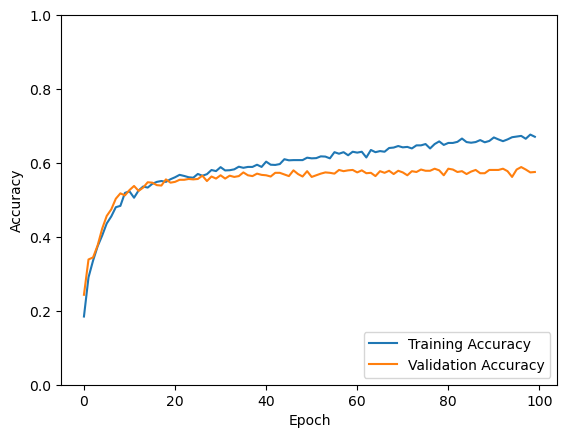

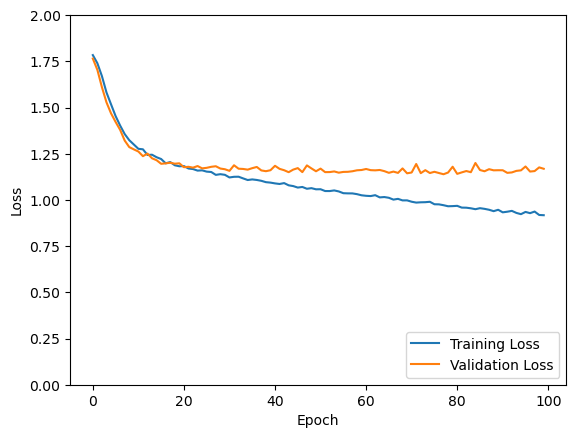

In [9]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

- Both the training and validation accuracy have a big increase in accuracy in the first few epochs but it quickly stagnates around 60% accuracy. This is an indicator that the model might not be able to capture the complexity our categorization within the defined layers.
- 